
--- Cross-Validation Results (on Training Set) ---
CV R² score for N2O: 0.827
CV RMSE for N2O: 0.030

--- Final Evaluation on Held-out Test Set ---
Test R² score for N2O: 0.822
Test RMSE for N2O: 0.032


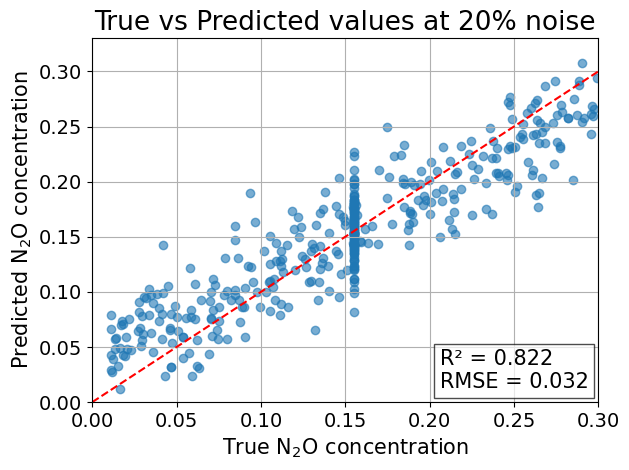

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import savgol_filter

gas = 'N2O'

# --- Load spectra and labels ---
spectra_df = pd.read_csv(f"{gas}_spectra_single_noisy.csv")
labels_df = pd.read_csv(f"{gas}_label_single.csv")
X = spectra_df
y = labels_df[[gas]]

# --- Standardize spectra ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, shuffle=True)

# --- Cross-validation on training set ---
cv = KFold(n_splits=10, shuffle=True)
n_components = 1
pls_cv = PLSRegression(n_components=n_components)

y_train_cv_pred = cross_val_predict(pls_cv, X_train, y_train, cv=cv)

# --- Evaluation on training (cross-val) ---
r2_cv = r2_score(y_train, y_train_cv_pred)
rmse_cv = mean_squared_error(y_train, y_train_cv_pred, squared=False)

print("\n--- Cross-Validation Results (on Training Set) ---")
print(f"CV R² score for {gas}: {r2_cv:.3f}")
print(f"CV RMSE for {gas}: {rmse_cv:.3f}")

# --- Final model on training set, evaluate on test set ---
pls_final = PLSRegression(n_components=n_components)
pls_final.fit(X_train, y_train)
y_test_pred = pls_final.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("\n--- Final Evaluation on Held-out Test Set ---")
print(f"Test R² score for {gas}: {r2_test:.3f}")
print(f"Test RMSE for {gas}: {rmse_test:.3f}")

# --- Plotting ---

# Test set prediction
plt.figure()
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.xlabel(f"True N$_2$O concentration", fontsize=15)
plt.ylabel(f"Predicted N$_2$O concentration", fontsize=15)
plt.xlim(0,0.3)
plt.ylim(0, 0.33)
plt.title(f"True vs Predicted values at 20% noise", fontsize=19)
plt.plot((0,0.3), (0,0.3), 'r--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.text(0.206, 0.0125, f"R² = {r2_test:.3f}\nRMSE = {rmse_test:.3f}", 
         fontsize=15, color='black',
         bbox=dict(facecolor='white', alpha=0.7))
plt.tight_layout()

plt.show()


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import savgol_filter

gas = 'N2O'

# --- Load spectra and labels ---
spectra_df = pd.read_csv(f"{gas}_spectra_single_noisy.csv")
labels_df = pd.read_csv(f"{gas}_label_single.csv")

# Drop index column if present
X = spectra_df.values
y = labels_df[[gas]]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Cross-validation for optimal components ---
max_components = min(X_scaled.shape[1], 30) 
r2_scores = []
rmse_scores = []

kf = KFold(n_splits=10, shuffle=True)

for n_comp in range(1, max_components + 1):
    pls = PLSRegression(n_components=n_comp)
    y_cv = cross_val_predict(pls, X_scaled, y, cv=kf)
    r2 = r2_score(y, y_cv)
    rmse = mean_squared_error(y, y_cv, squared=False)
    r2_scores.append(r2)
    rmse_scores.append(rmse)


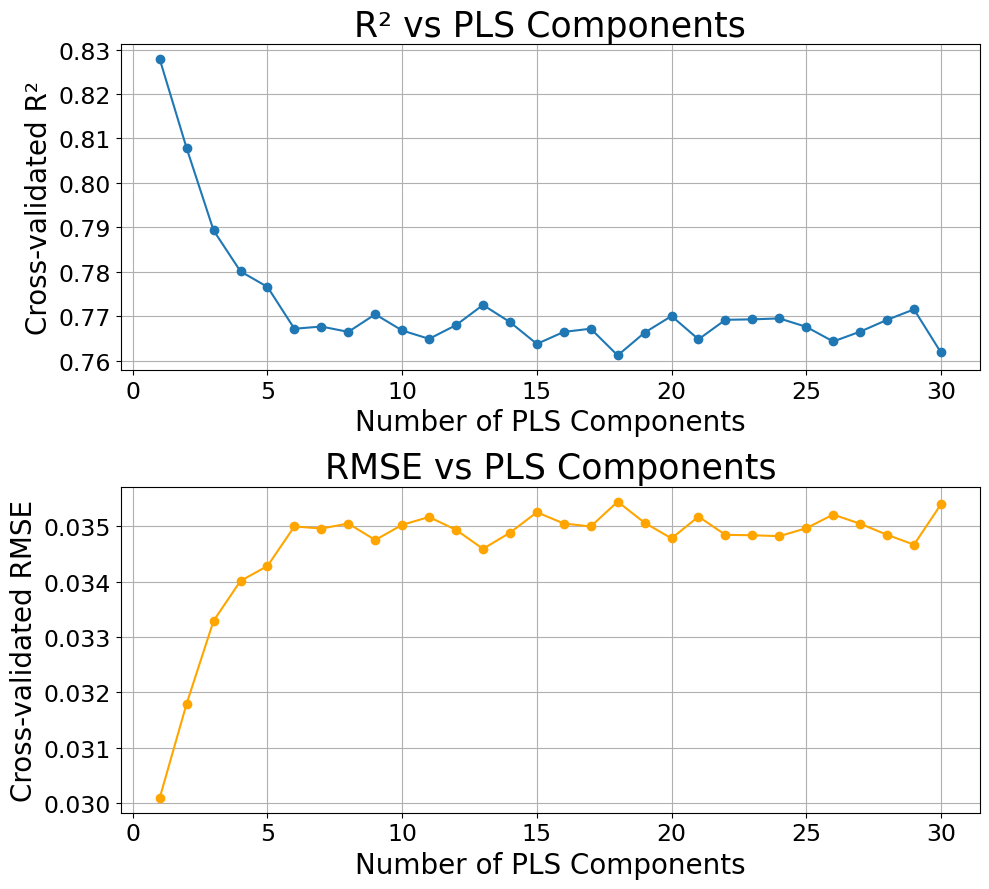

Optimal number of PLS components: 1


In [75]:
# --- Plot metrics ---
plt.figure(figsize=(10, 9))

# Top plot: R² vs PLS components
plt.subplot(2, 1, 1)
plt.plot(range(1, max_components + 1), r2_scores, marker='o')
plt.xlabel('Number of PLS Components', fontsize=20)
plt.ylabel('Cross-validated R²', fontsize=20)
plt.title('R² vs PLS Components', fontsize=25)
plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Bottom plot: RMSE vs PLS components
plt.subplot(2, 1, 2)
plt.plot(range(1, max_components + 1), rmse_scores, marker='o', color='orange')
plt.xlabel('Number of PLS Components', fontsize=20)
plt.ylabel('Cross-validated RMSE', fontsize=20)
plt.title('RMSE vs PLS Components', fontsize=25)
plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.tight_layout()
plt.show()

# --- Optimal number of components ---
optimal_components = np.argmax(r2_scores) + 1
print(f"Optimal number of PLS components: {optimal_components}")
